# Fluorescence Spectrum error propagation validation
Propagating the uncertainties of the quantum efficiencies, the
wavelength calibration and the background subtraction to the final
spectrum is not trivial. In the `spectrum` method of the 
`agepy.spec.photons.Spectrum` class the error propagation is performed
using Monte Carlo error propagation.
In order to test this approaches a study is performed using a "true"
spectrum and "known" quantum efficiencies and calibration parameters
each with "known" uncertainties based on which samples are drawn.

In [1]:
import numpy as np
from scipy.stats import norm, beta
import matplotlib.pyplot as plt
from agepy.spec.photons import Spectrum
from agepy import ageplot
ageplot.use("age")

In [2]:
# Define a binning for the spectrum
xedges = np.histogram([], bins=256, range=(128.67, 128.67 + 38.94))[1]
# Define a region of interest
roi = ((0.2, 0.8), (0, 1))
# Define detector positions for the efficiency values
qeff_x = np.linspace(0.1, 0.9, 30)
# Create a random number generator
rng = np.random.default_rng()

First, a background measurement is simulated for a uniform background:

In [3]:
# Simulate a background measurement
bkg = np.stack([rng.random(100000), np.ones(100000) * 0.5], axis=1)
bkg = Spectrum(bkg, time=240 * 50)

The following function simulates one sample of the true spectrum with
"realistic" conditions corresponding to a single measurement.
The true spectrum has 25000 counts, but each sample's number of counts
`n` is based on a random number drawn from a Poisson distribution.
The true spectrum consits of one Gaussian and a beta distribution, from
which random numbers are drawn to simulate the measure photon hits.
The same is done for the background with 2000 background events.
The known quantum efficiencies are 0.9 everywhere on the detector, but
only known at 30 positions on the detector with measurement
uncertainties of 0.1 at each point.
For the sample the efficiencies are randomly generated from a normal
distribution.
The same procedure is applied to the wavelength calibration parameters.
For this sample the spectrum and the uncertainties are calculated.

In [4]:
def simulate_measurement(err_prop, mc_samples=10000):
    # Simulate the number of photons
    nsig1 = rng.poisson(lam=5000)
    nsig2 = rng.poisson(lam=20000)
    # Simulate the number of background events
    nbkg = rng.poisson(lam=2000)

    # Simulate the photon hits
    xsig1 = rng.normal(0.3, 0.01, nsig1)
    xsig2 = rng.beta(2, 7, nsig2) * 0.5 + 0.4
    xbkg = rng.random(nbkg)
    xdata = np.concatenate((xsig1, xsig2, xbkg))
    ydata = np.ones(nsig1 + nsig2 + nbkg) * 0.5
    data = np.stack([xdata, ydata], axis=1)

    # Create the spectrum object
    spectrum = Spectrum(data, time=240)

    # Simulate detector efficiency measurement
    qeff_val = rng.normal(0.9, 0.1, 30)
    qeff_err = np.ones(30) * 0.1
    qeff = (qeff_val, qeff_err, qeff_x)

    # Simulate calibration
    a0 = rng.normal(128.67, 0.07)
    a1 = rng.normal(38.94, 0.01)
    calib = ((a0, 0.07), (a1, 0.01))

    # Simulate the spectrum
    return spectrum.spectrum(xedges, roi=roi, qeff=qeff, bkg=bkg, calib=calib, err_prop=err_prop, mc_samples=mc_samples)

First, a Monte Carlo simulation is performed in order to get the correct
uncertainties on the bin counts. This is done by calculating the
spectrum for 100000 samples without caring about returned uncertainties
and instead getting the "true" uncertainties by calculating the
standard deviation of the 100000 spectra.

In [5]:
true_spec = np.zeros((100000, len(xedges) - 1), dtype=np.float64)

for i in range(100000):
    true_spec[i] = simulate_measurement("none")[0]

# Calculate the "true" uncertainties
true_err = np.std(true_spec, ddof=1, axis=0)
true_spec = np.mean(true_spec, axis=0)

The error propagation is then performed for single samples 100 times and
the returned uncertainties are averaged in order to get a more
significant result.

In [6]:
mc_err = np.zeros((100, len(xedges) - 1), dtype=np.float64)

for i in range(100):
    mc_err[i] = simulate_measurement("montecarlo", mc_samples=10000)[1]

# Calculate the mean of the Monte Carlo uncertainties
mc_err_err = np.std(mc_err, ddof=1, axis=0)
mc_err = np.mean(mc_err, axis=0)

Additionaly, the Monte Carlo error propagation is performed for one
sample with an increased number of error propagation Monte Carlo samples.

In [7]:
sample, sample_err = simulate_measurement("montecarlo", mc_samples=500000)

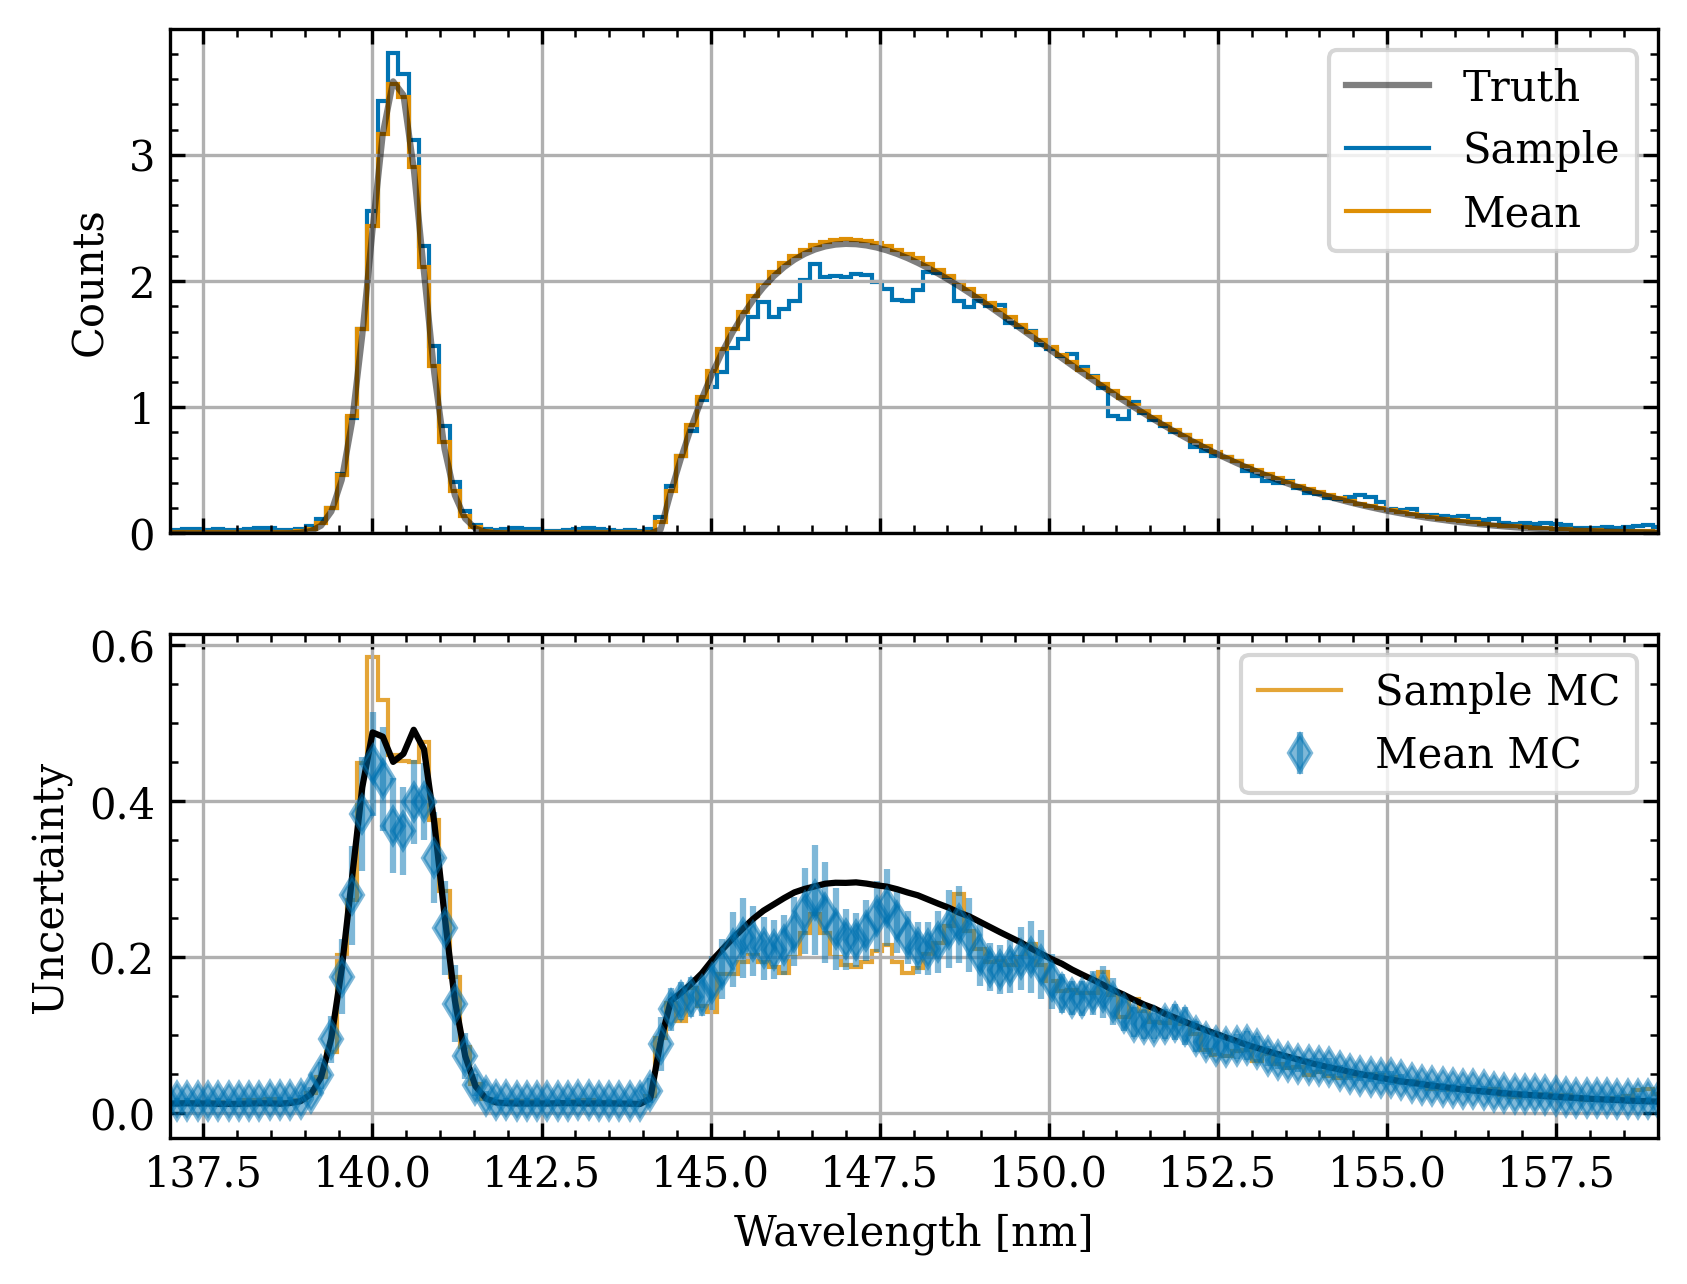

In [8]:
fig, ax = plt.subplots(2, 1, sharex=True)
dx = (xedges[1] - xedges[0])
# Calculate the bin centers
xvalues = (xedges[1:] + xedges[:-1]) * 0.5
# Plot the true distribution
loc = 0.3 * 38.94 + 128.67
scale = 0.01 * 38.94
c = dx / 240 / 0.9
truth = 5000 * c * norm.pdf(xvalues, loc=loc, scale=scale)
loc = 0.4 * 38.94 + 128.67
scale = 0.5 * 38.94
truth += 20000 * c * beta.pdf(xvalues, 2, 7, loc=loc, scale=scale)
ax[0].plot(xvalues, truth, color="k", alpha=0.5, label="Truth")
# Plot the sample spectrum
ax[0].stairs(sample, xedges, color=ageplot.colors[0], label="Sample")
# Plot the mean of the 100000 spectra
ax[0].stairs(true_spec, xedges, color=ageplot.colors[1], label="Mean")
ax[0].legend()
ax[0].set_ylabel("Counts")
# Plot the mean uncertainties and their standard deviation
ax[1].errorbar(xvalues, mc_err, yerr=mc_err_err, fmt="d", color=ageplot.colors[0], alpha=0.5, label="Mean MC")
# Plot the uncertainties of the sample spectrum
ax[1].stairs(sample_err, xedges, color=ageplot.colors[1], alpha=0.8, label="Sample MC")
# Plot the true uncertainties (standard deviation of the 100000 spectra)
ax[1].plot(xvalues, true_err, color="k")
ax[1].set_xlim(137, 159)
ax[1].set_xlabel("Wavelength [nm]")
ax[1].set_ylabel("Uncertainty")
ax[1].legend()
plt.show()